In [1]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce
import datetime


In [2]:
L = 4 #system size
M = 0.1 #fermion mass
N=3 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [3]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [4]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [5]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [6]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [7]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [8]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [9]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [10]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [11]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [12]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(LL+1):
    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [13]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-9.29176933e-01 -3.13068105e-01 -3.92832140e-16]


In [14]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [15]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-4:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.49289322]
(-0.06886927321591567-0.004720730331859947j)|2 2 0 1>
(0.1556248819478617+0.01066750186690274j)|2 2 0 0>
(-0.281763738721118-0.019313847318057704j)|2 1 1 1>
(0.07524961166408105+0.00515807859811262j)|2 1 0 1>
(0.06886927321591436+0.004720730331860938j)|2 1 0 0>
(-0.2817637387211185-0.019313847318062693j)|1 1 1 2>
(0.7739670822407763+0.05305254012972949j)|1 1 1 1>
(-0.28176373872111576-0.019313847318056417j)|1 1 0 1>
(0.06886927321591277+0.004720730331855866j)|1 0 2 2>
(0.07524961166408055+0.005158078598125558j)|1 0 1 2>
(-0.28176373872111676-0.019313847318070752j)|1 0 1 1>
(0.15562488194786148+0.010667501866898715j)|0 0 2 2>
(-0.06886927321591474-0.004720730331853797j)|0 0 1 2>



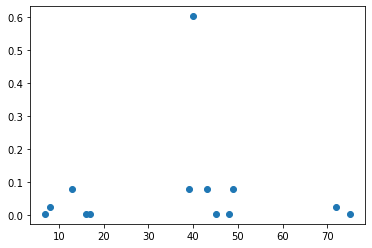

In [16]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [17]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    sigma_e = rot_sigma(0,i,j,phi,theta)@rot_sigma(3,i,j,phi,theta)
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    sigma_o = rot_sigma(1,i,j,phi,theta)@rot_sigma(2,i,j,phi,theta)
    return(sigma_o)



def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    sigma_e = sigma(0,i,j,phi) + sigma(3,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    sigma_o = sigma(1,i,j,phi) + sigma(2,i,j,phi)
    return sigma_o


In [18]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()


def ms_hamiltonian_2(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe@summe@summe
                
matrix_part_2 = ms_hamiltonian_2(1,2,0)
ms_ham_eigenval_2, ms_ham_eigenvec_2 = scipy.linalg.eigh(matrix_part_2)




def ms_gate_global_2(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_2[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_2@exponential@ms_ham_eigenvec_2.T.conj()


    
    
    
    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z
        
    summe = sigma_big_p[0]@sigma_big_p[1]@sigma_big_m[2]@sigma_big_m[3]+sigma_big_m[0]@sigma_big_m[1]@sigma_big_p[2]@sigma_big_p[3]

        
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [19]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [20]:
def R(i,theta):
    
    if i%14 == 0:
        return(ms_gate_global(theta))

    if i%14 == 1:
        return(ms_gate_global_1(theta))
    
    if i%14 == 2:
        return(rot_sigma(3,0,1,0,theta).toarray())


    if i%14 == 3:
        return(rot_sigma(3,0,2,0,theta).toarray())

    
    if i%14 == 4:
        return(rot_sigma(3,1,2,np.pi/2,theta).toarray())
    
    
    if i%14 == 5:
        return(rot_sigma(2,0,1,0,theta).toarray())


    if i%14 == 6:
        return(rot_sigma(2,0,2,0,theta).toarray())

    
    if i%14 == 7:
        return(rot_sigma(2,1,2,np.pi/2,theta).toarray())
    

    if i%14 == 8:
        return(rot_sigma(1,0,1,0,theta).toarray())


    if i%14 == 9:
        return(rot_sigma(1,0,2,0,theta).toarray())

    
    if i%14 == 10:
        return(rot_sigma(1,1,2,np.pi/2,theta).toarray())
    
    
    if i%14 == 11:
        return(rot_sigma(0,0,1,0,theta).toarray())


    if i%14 == 12:
        return(rot_sigma(0,0,2,0,theta).toarray())

    
    if i%14 == 13:
        return(rot_sigma(0,1,2,np.pi/2,theta).toarray())
    
    
def S(i):
    
    if i%14 == 0:
        return(-1j*matrix_part)

    if i%14 == 1:
        return(-1j*matrix_part_1)

    if i%14 == 2:
        return(-1j*sigma(3,0,1,0).toarray())

    
    if i%14 == 3:
        return(-1j*sigma(3,0,2,0).toarray())

    
    if i%14 == 4:
        return(-1j*sigma(3,1,2,np.pi/2).toarray())


     
    if i%14 == 5:
        return(-1j*sigma(2,0,1,0).toarray())

    
    if i%14 == 6:
        return(-1j*sigma(2,0,2,0).toarray())

    
    if i%14 == 7:
        return(-1j*sigma(2,1,2,np.pi/2).toarray())


    if i%14 == 8:
        return(-1j*sigma(1,0,1,0).toarray())

    
    if i%14 == 9:
        return(-1j*sigma(1,0,2,0).toarray())

    
    if i%14 == 10:
        return(-1j*sigma(1,1,2,np.pi/2).toarray())

     
    if i%14 == 11:
        return(-1j*sigma(0,0,1,0).toarray())

    
    if i%14 == 12:
        return(-1j*sigma(0,0,2,0).toarray())

    
    if i%14 == 13:
        return(-1j*sigma(0,1,2,np.pi/2).toarray())

In [21]:
coeff = 14

In [22]:
matr = full_ham_matrix.toarray()
ones = np.ones(coeff*N)
ID = np.identity(coeff*N)
psi_0_conj = np.conj(psi_0)
A = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
dd = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]


In [23]:
def rhs(t,theta):
    #A = [-1j*entanglement_ham.toarray()@exp_ent(theta[0]),-1j*sigma_z.toarray()@exp_sigma_z(theta[1]),-1j*sigma_x.toarray()@exp_sigma_x(theta[2]),-1j*sigma_z.toarray()@exp_sigma_z(theta[3])]
    #B = [exp_ent(theta[0]),exp_sigma_z(theta[1]),exp_sigma_x(theta[2]),exp_sigma_z(theta[3])]
    ID = np.identity(coeff*N)

    print(datetime.datetime.now())
    for k in range(coeff*N):
        A[k] = S(k)@R(k,theta[k])
        B[k] = R(k,theta[k])

    CC = np.einsum("i,ljk->iljk",np.ones(coeff*N),B)

    AA = np.einsum("ijk,il->iljk",A,ID)

    BB = np.einsum("ijk,il->iljk",B,ID)

    DD = CC-BB+AA

    for i in range(coeff*N):
        dd[i] = reduce(np.dot,DD[i])
    DD = np.array(dd)

    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)

    BBB = reduce(np.dot,B)
    DD_d = np.einsum("kij->kji",DD.conj())
    BBB_dagger = BBB.conj().T

    
    
    psi_conj_d = np.einsum("m,imn->in",psi_0_conj,DD_d)
    psi_d = np.einsum("jnl,l->jn",DD,psi_0)
    
    psi_conj_b = np.einsum("m,mn->n",psi_0_conj,BBB_dagger)
    psi_b = np.einsum("lk,k->l",BBB,psi_0)

    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [24]:
stepp = 1000
t_final = 10

In [25]:
time_domain = np.linspace(0, t_final, stepp)
Y = []

In [26]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [27]:
start_point = 0.001*np.ones(coeff*N)
#for i in range(4*N):
#    start_point[i] += i/4*N
rk4(0,0.001*np.ones(coeff*N),t_final,stepp)


2022-07-25 11:44:11.446656
2022-07-25 11:44:11.982853
0
2022-07-25 11:44:11.984310
2022-07-25 11:44:12.465540
0.005
2022-07-25 11:44:12.467263
2022-07-25 11:44:12.956390
0.005
2022-07-25 11:44:12.957820
2022-07-25 11:44:13.437879
0.01
2022-07-25 11:44:13.439316
2022-07-25 11:44:13.942115
0.01
2022-07-25 11:44:13.943611
2022-07-25 11:44:14.446367
0.015
2022-07-25 11:44:14.447909
2022-07-25 11:44:15.008356
0.015
2022-07-25 11:44:15.010118
2022-07-25 11:44:15.500134
0.02
2022-07-25 11:44:15.501588
2022-07-25 11:44:15.985689
0.02
2022-07-25 11:44:15.987155
2022-07-25 11:44:16.508902
0.025
2022-07-25 11:44:16.510858
2022-07-25 11:44:17.018348
0.025
2022-07-25 11:44:17.019821
2022-07-25 11:44:17.520685
0.03
2022-07-25 11:44:17.522148
2022-07-25 11:44:18.025196
0.03
2022-07-25 11:44:18.026603
2022-07-25 11:44:18.511002
0.034999999999999996
2022-07-25 11:44:18.512607
2022-07-25 11:44:18.994281
0.034999999999999996
2022-07-25 11:44:18.995794
2022-07-25 11:44:19.509563
0.04
2022-07-25 11:44:19.5

2022-07-25 11:45:23.585871
0.3000000000000001
2022-07-25 11:45:23.587583
2022-07-25 11:45:24.218611
0.3050000000000001
2022-07-25 11:45:24.220315
2022-07-25 11:45:24.845272
0.3050000000000001
2022-07-25 11:45:24.847379
2022-07-25 11:45:25.476860
0.3100000000000001
2022-07-25 11:45:25.478852
2022-07-25 11:45:26.108794
0.3100000000000001
2022-07-25 11:45:26.110473
2022-07-25 11:45:26.742336
0.3150000000000001
2022-07-25 11:45:26.744489
2022-07-25 11:45:27.368753
0.3150000000000001
2022-07-25 11:45:27.370648
2022-07-25 11:45:27.995998
0.3200000000000001
2022-07-25 11:45:27.997921
2022-07-25 11:45:28.622780
0.3200000000000001
2022-07-25 11:45:28.624957
2022-07-25 11:45:29.250814
0.3250000000000001
2022-07-25 11:45:29.252709
2022-07-25 11:45:29.883096
0.3250000000000001
2022-07-25 11:45:29.884787
2022-07-25 11:45:30.518154
0.3300000000000001
2022-07-25 11:45:30.520141
2022-07-25 11:45:31.150392
0.3300000000000001
2022-07-25 11:45:31.152076
2022-07-25 11:45:31.785674
0.33500000000000013
2022

2022-07-25 11:46:34.375160
0.5800000000000003
2022-07-25 11:46:34.377408
2022-07-25 11:46:35.006944
0.5850000000000003
2022-07-25 11:46:35.008598
2022-07-25 11:46:35.638669
0.5850000000000003
2022-07-25 11:46:35.640615
2022-07-25 11:46:36.264792
0.5900000000000003
2022-07-25 11:46:36.266469
2022-07-25 11:46:36.888212
0.5900000000000003
2022-07-25 11:46:36.890300
2022-07-25 11:46:37.513158
0.5950000000000003
2022-07-25 11:46:37.515046
2022-07-25 11:46:38.141467
0.5950000000000003
2022-07-25 11:46:38.143335
2022-07-25 11:46:38.763768
0.6000000000000003
2022-07-25 11:46:38.765501
2022-07-25 11:46:39.386210
0.6000000000000003
2022-07-25 11:46:39.388154
2022-07-25 11:46:40.018015
0.6050000000000003
2022-07-25 11:46:40.019979
2022-07-25 11:46:40.640090
0.6050000000000003
2022-07-25 11:46:40.642246
2022-07-25 11:46:41.270326
0.6100000000000003
2022-07-25 11:46:41.272244
2022-07-25 11:46:41.900195
0.6100000000000003
2022-07-25 11:46:41.901848
2022-07-25 11:46:42.523883
0.6150000000000003
2022-

2022-07-25 11:47:45.294499
0.8650000000000005
2022-07-25 11:47:45.296283
2022-07-25 11:47:45.925426
0.8650000000000005
2022-07-25 11:47:45.927316
2022-07-25 11:47:46.544974
0.8700000000000006
2022-07-25 11:47:46.546958
2022-07-25 11:47:47.219672
0.8700000000000006
2022-07-25 11:47:47.221701
2022-07-25 11:47:47.889428
0.8750000000000006
2022-07-25 11:47:47.891413
2022-07-25 11:47:48.519504
0.8750000000000006
2022-07-25 11:47:48.521626
2022-07-25 11:47:49.162353
0.8800000000000006
2022-07-25 11:47:49.164165
2022-07-25 11:47:49.805729
0.8800000000000006
2022-07-25 11:47:49.807390
2022-07-25 11:47:50.427564
0.8850000000000006
2022-07-25 11:47:50.429356
2022-07-25 11:47:51.054677
0.8850000000000006
2022-07-25 11:47:51.056477
2022-07-25 11:47:51.685679
0.8900000000000006
2022-07-25 11:47:51.687463
2022-07-25 11:47:52.308421
0.8900000000000006
2022-07-25 11:47:52.310519
2022-07-25 11:47:52.940918
0.8950000000000006
2022-07-25 11:47:52.942694
2022-07-25 11:47:53.561247
0.8950000000000006
2022-

2022-07-25 11:48:56.922353
1.1450000000000007
2022-07-25 11:48:56.924318
2022-07-25 11:48:57.559315
1.1500000000000008
2022-07-25 11:48:57.561309
2022-07-25 11:48:58.186077
1.1500000000000008
2022-07-25 11:48:58.188000
2022-07-25 11:48:58.814622
1.1550000000000007
2022-07-25 11:48:58.816745
2022-07-25 11:48:59.444345
1.1550000000000007
2022-07-25 11:48:59.446308
2022-07-25 11:49:00.077507
1.1600000000000008
2022-07-25 11:49:00.079483
2022-07-25 11:49:00.709918
1.1600000000000008
2022-07-25 11:49:00.711885
2022-07-25 11:49:01.339333
1.1650000000000007
2022-07-25 11:49:01.341213
2022-07-25 11:49:01.975208
1.1650000000000007
2022-07-25 11:49:01.977406
2022-07-25 11:49:02.605394
1.1700000000000008
2022-07-25 11:49:02.607288
2022-07-25 11:49:03.238051
1.1700000000000008
2022-07-25 11:49:03.239988
2022-07-25 11:49:03.866140
1.1750000000000007
2022-07-25 11:49:03.868363
2022-07-25 11:49:04.492546
1.1750000000000007
2022-07-25 11:49:04.494286
2022-07-25 11:49:05.124344
1.1800000000000008
2022-

2022-07-25 11:50:08.251174
1.430000000000001
2022-07-25 11:50:08.253126
2022-07-25 11:50:08.879548
1.430000000000001
2022-07-25 11:50:08.881217
2022-07-25 11:50:09.508152
1.435000000000001
2022-07-25 11:50:09.509804
2022-07-25 11:50:10.136508
1.435000000000001
2022-07-25 11:50:10.138440
2022-07-25 11:50:10.763971
1.440000000000001
2022-07-25 11:50:10.766010
2022-07-25 11:50:11.395573
1.440000000000001
2022-07-25 11:50:11.397438
2022-07-25 11:50:12.024277
1.445000000000001
2022-07-25 11:50:12.025948
2022-07-25 11:50:12.652482
1.445000000000001
2022-07-25 11:50:12.654348
2022-07-25 11:50:13.284134
1.450000000000001
2022-07-25 11:50:13.286040
2022-07-25 11:50:13.915980
1.450000000000001
2022-07-25 11:50:13.917911
2022-07-25 11:50:14.544239
1.455000000000001
2022-07-25 11:50:14.545926
2022-07-25 11:50:15.171434
1.455000000000001
2022-07-25 11:50:15.173262
2022-07-25 11:50:15.797887
1.460000000000001
2022-07-25 11:50:15.799536
2022-07-25 11:50:16.424850
1.460000000000001
2022-07-25 11:50:16

2022-07-25 11:51:19.450391
1.7100000000000013
2022-07-25 11:51:19.452328
2022-07-25 11:51:20.174612
1.7150000000000012
2022-07-25 11:51:20.176538
2022-07-25 11:51:20.917075
1.7150000000000012
2022-07-25 11:51:20.920108
2022-07-25 11:51:21.610911
1.7200000000000013
2022-07-25 11:51:21.612948
2022-07-25 11:51:22.295411
1.7200000000000013
2022-07-25 11:51:22.297389
2022-07-25 11:51:22.950936
1.7250000000000012
2022-07-25 11:51:22.952846
2022-07-25 11:51:23.601796
1.7250000000000012
2022-07-25 11:51:23.603449
2022-07-25 11:51:24.218334
1.7300000000000013
2022-07-25 11:51:24.219937
2022-07-25 11:51:24.852262
1.7300000000000013
2022-07-25 11:51:24.853902
2022-07-25 11:51:25.480089
1.7350000000000012
2022-07-25 11:51:25.481742
2022-07-25 11:51:26.110547
1.7350000000000012
2022-07-25 11:51:26.112317
2022-07-25 11:51:26.741923
1.7400000000000013
2022-07-25 11:51:26.743820
2022-07-25 11:51:27.366364
1.7400000000000013
2022-07-25 11:51:27.368116
2022-07-25 11:51:28.001818
1.7450000000000012
2022-

2022-07-25 11:52:31.485282
1.9950000000000014
2022-07-25 11:52:31.487051
2022-07-25 11:52:32.110176
1.9950000000000014
2022-07-25 11:52:32.111942
2022-07-25 11:52:32.747214
2.0000000000000013
2022-07-25 11:52:32.749008
2022-07-25 11:52:33.374245
2.0000000000000013
2022-07-25 11:52:33.376166
2022-07-25 11:52:34.007926
2.0050000000000012
2022-07-25 11:52:34.009938
2022-07-25 11:52:34.642403
2.0050000000000012
2022-07-25 11:52:34.644520
2022-07-25 11:52:35.275192
2.010000000000001
2022-07-25 11:52:35.276798
2022-07-25 11:52:35.910356
2.010000000000001
2022-07-25 11:52:35.911951
2022-07-25 11:52:36.545762
2.015000000000001
2022-07-25 11:52:36.547924
2022-07-25 11:52:37.173192
2.015000000000001
2022-07-25 11:52:37.175279
2022-07-25 11:52:37.827159
2.020000000000001
2022-07-25 11:52:37.828804
2022-07-25 11:52:38.449237
2.020000000000001
2022-07-25 11:52:38.451177
2022-07-25 11:52:39.082044
2.025000000000001
2022-07-25 11:52:39.084012
2022-07-25 11:52:39.715826
2.025000000000001
2022-07-25 11

2022-07-25 11:53:44.731553
2.2799999999999954
2022-07-25 11:53:44.733254
2022-07-25 11:53:45.466169
2.2849999999999953
2022-07-25 11:53:45.468127
2022-07-25 11:53:46.150985
2.2849999999999953
2022-07-25 11:53:46.152686
2022-07-25 11:53:46.830129
2.289999999999995
2022-07-25 11:53:46.832099
2022-07-25 11:53:47.595556
2.289999999999995
2022-07-25 11:53:47.597475
2022-07-25 11:53:48.297157
2.294999999999995
2022-07-25 11:53:48.298926
2022-07-25 11:53:48.978699
2.294999999999995
2022-07-25 11:53:48.980694
2022-07-25 11:53:49.667283
2.299999999999995
2022-07-25 11:53:49.669309
2022-07-25 11:53:50.358704
2.299999999999995
2022-07-25 11:53:50.361342
2022-07-25 11:53:51.082639
2.304999999999995
2022-07-25 11:53:51.084417
2022-07-25 11:53:51.880502
2.304999999999995
2022-07-25 11:53:51.882633
2022-07-25 11:53:52.630655
2.3099999999999947
2022-07-25 11:53:52.632798
2022-07-25 11:53:53.404692
2.3099999999999947
2022-07-25 11:53:53.407112
2022-07-25 11:53:54.376179
2.3149999999999946
2022-07-25 11

2022-07-25 11:55:07.639277
2.5649999999999893
2022-07-25 11:55:07.641405
2022-07-25 11:55:08.297901
2.569999999999989
2022-07-25 11:55:08.299943
2022-07-25 11:55:08.977731
2.569999999999989
2022-07-25 11:55:08.979945
2022-07-25 11:55:09.628424
2.574999999999989
2022-07-25 11:55:09.630393
2022-07-25 11:55:10.286941
2.574999999999989
2022-07-25 11:55:10.288641
2022-07-25 11:55:10.929071
2.579999999999989
2022-07-25 11:55:10.930748
2022-07-25 11:55:11.577646
2.579999999999989
2022-07-25 11:55:11.579367
2022-07-25 11:55:12.231328
2.584999999999989
2022-07-25 11:55:12.233347
2022-07-25 11:55:12.881074
2.584999999999989
2022-07-25 11:55:12.882729
2022-07-25 11:55:13.525185
2.5899999999999888
2022-07-25 11:55:13.527165
2022-07-25 11:55:14.168284
2.5899999999999888
2022-07-25 11:55:14.169956
2022-07-25 11:55:14.819180
2.5949999999999886
2022-07-25 11:55:14.821080
2022-07-25 11:55:15.460771
2.5949999999999886
2022-07-25 11:55:15.462707
2022-07-25 11:55:16.127707
2.5999999999999885
2022-07-25 11

2022-07-25 11:56:23.277653
2.849999999999983
2022-07-25 11:56:23.280214
2022-07-25 11:56:23.995152
2.849999999999983
2022-07-25 11:56:23.997791
2022-07-25 11:56:24.653908
2.854999999999983
2022-07-25 11:56:24.655700
2022-07-25 11:56:25.292807
2.854999999999983
2022-07-25 11:56:25.294562
2022-07-25 11:56:25.928147
2.859999999999983
2022-07-25 11:56:25.930033
2022-07-25 11:56:26.557562
2.859999999999983
2022-07-25 11:56:26.559653
2022-07-25 11:56:27.194301
2.864999999999983
2022-07-25 11:56:27.196234
2022-07-25 11:56:27.826187
2.864999999999983
2022-07-25 11:56:27.827894
2022-07-25 11:56:28.463912
2.869999999999983
2022-07-25 11:56:28.465806
2022-07-25 11:56:29.092683
2.869999999999983
2022-07-25 11:56:29.094634
2022-07-25 11:56:29.738491
2.8749999999999827
2022-07-25 11:56:29.740570
2022-07-25 11:56:30.366780
2.8749999999999827
2022-07-25 11:56:30.368556
2022-07-25 11:56:31.000775
2.8799999999999826
2022-07-25 11:56:31.002561
2022-07-25 11:56:31.632629
2.8799999999999826
2022-07-25 11:5

2022-07-25 11:57:35.614965
3.134999999999977
2022-07-25 11:57:35.616886
2022-07-25 11:57:36.245120
3.134999999999977
2022-07-25 11:57:36.246876
2022-07-25 11:57:36.881130
3.139999999999977
2022-07-25 11:57:36.882843
2022-07-25 11:57:37.517995
3.139999999999977
2022-07-25 11:57:37.519698
2022-07-25 11:57:38.144965
3.144999999999977
2022-07-25 11:57:38.146733
2022-07-25 11:57:38.774630
3.144999999999977
2022-07-25 11:57:38.776318
2022-07-25 11:57:39.403386
3.149999999999977
2022-07-25 11:57:39.405363
2022-07-25 11:57:40.031663
3.149999999999977
2022-07-25 11:57:40.033556
2022-07-25 11:57:40.664884
3.1549999999999767
2022-07-25 11:57:40.666639
2022-07-25 11:57:41.295393
3.1549999999999767
2022-07-25 11:57:41.297064
2022-07-25 11:57:41.930185
3.1599999999999766
2022-07-25 11:57:41.931861
2022-07-25 11:57:42.563346
3.1599999999999766
2022-07-25 11:57:42.565074
2022-07-25 11:57:43.192740
3.1649999999999765
2022-07-25 11:57:43.194325
2022-07-25 11:57:43.823857
3.1649999999999765
2022-07-25 11

2022-07-25 11:58:49.546769
3.414999999999971
2022-07-25 11:58:49.548709
2022-07-25 11:58:50.260246
3.419999999999971
2022-07-25 11:58:50.262498
2022-07-25 11:58:50.912905
3.419999999999971
2022-07-25 11:58:50.915160
2022-07-25 11:58:51.586390
3.424999999999971
2022-07-25 11:58:51.588671
2022-07-25 11:58:52.247084
3.424999999999971
2022-07-25 11:58:52.248885
2022-07-25 11:58:52.915511
3.429999999999971
2022-07-25 11:58:52.917548
2022-07-25 11:58:53.589789
3.429999999999971
2022-07-25 11:58:53.592074
2022-07-25 11:58:54.247691
3.4349999999999707
2022-07-25 11:58:54.249670
2022-07-25 11:58:54.925222
3.4349999999999707
2022-07-25 11:58:54.928222
2022-07-25 11:58:55.670720
3.4399999999999706
2022-07-25 11:58:55.673097
2022-07-25 11:58:56.339893
3.4399999999999706
2022-07-25 11:58:56.341644
2022-07-25 11:58:57.012793
3.4449999999999705
2022-07-25 11:58:57.014869
2022-07-25 11:58:57.696344
3.4449999999999705
2022-07-25 11:58:57.698150
2022-07-25 11:58:58.358932
3.4499999999999704
2022-07-25 1

2022-07-25 12:00:04.452240
3.699999999999965
2022-07-25 12:00:04.454156
2022-07-25 12:00:05.079216
3.704999999999965
2022-07-25 12:00:05.081464
2022-07-25 12:00:05.710199
3.704999999999965
2022-07-25 12:00:05.712072
2022-07-25 12:00:06.340126
3.709999999999965
2022-07-25 12:00:06.342024
2022-07-25 12:00:06.971287
3.709999999999965
2022-07-25 12:00:06.973227
2022-07-25 12:00:07.602718
3.7149999999999648
2022-07-25 12:00:07.604329
2022-07-25 12:00:08.235392
3.7149999999999648
2022-07-25 12:00:08.237124
2022-07-25 12:00:08.866804
3.7199999999999647
2022-07-25 12:00:08.868712
2022-07-25 12:00:09.499427
3.7199999999999647
2022-07-25 12:00:09.501142
2022-07-25 12:00:10.129834
3.7249999999999646
2022-07-25 12:00:10.131821
2022-07-25 12:00:10.762683
3.7249999999999646
2022-07-25 12:00:10.764570
2022-07-25 12:00:11.406779
3.7299999999999645
2022-07-25 12:00:11.408694
2022-07-25 12:00:12.039178
3.7299999999999645
2022-07-25 12:00:12.041089
2022-07-25 12:00:12.671345
3.7349999999999643
2022-07-25

2022-07-25 12:01:16.998716
3.984999999999959
2022-07-25 12:01:17.000557
2022-07-25 12:01:17.634130
3.989999999999959
2022-07-25 12:01:17.636243
2022-07-25 12:01:18.265467
3.989999999999959
2022-07-25 12:01:18.267356
2022-07-25 12:01:18.894989
3.994999999999959
2022-07-25 12:01:18.896631
2022-07-25 12:01:19.525110
3.994999999999959
2022-07-25 12:01:19.527041
2022-07-25 12:01:20.161708
3.9999999999999587
2022-07-25 12:01:20.163622
2022-07-25 12:01:20.795086
3.9999999999999587
2022-07-25 12:01:20.796727
2022-07-25 12:01:21.428141
4.004999999999959
2022-07-25 12:01:21.430364
2022-07-25 12:01:22.060371
4.004999999999959
2022-07-25 12:01:22.062037
2022-07-25 12:01:22.694528
4.009999999999959
2022-07-25 12:01:22.696270
2022-07-25 12:01:23.334007
4.009999999999959
2022-07-25 12:01:23.335983
2022-07-25 12:01:23.970930
4.014999999999959
2022-07-25 12:01:23.972584
2022-07-25 12:01:24.602104
4.014999999999959
2022-07-25 12:01:24.604070
2022-07-25 12:01:25.235595
4.019999999999959
2022-07-25 12:01:

2022-07-25 12:02:32.347807
4.269999999999953
2022-07-25 12:02:32.349688
2022-07-25 12:02:33.119868
4.274999999999953
2022-07-25 12:02:33.121645
2022-07-25 12:02:33.834847
4.274999999999953
2022-07-25 12:02:33.836934
2022-07-25 12:02:34.551494
4.279999999999953
2022-07-25 12:02:34.553474
2022-07-25 12:02:35.272623
4.279999999999953
2022-07-25 12:02:35.275080
2022-07-25 12:02:35.992559
4.284999999999953
2022-07-25 12:02:35.994474
2022-07-25 12:02:36.692570
4.284999999999953
2022-07-25 12:02:36.694494
2022-07-25 12:02:37.360308
4.289999999999953
2022-07-25 12:02:37.362168
2022-07-25 12:02:38.018832
4.289999999999953
2022-07-25 12:02:38.020753
2022-07-25 12:02:38.684871
4.294999999999953
2022-07-25 12:02:38.686766
2022-07-25 12:02:39.351402
4.294999999999953
2022-07-25 12:02:39.353346
2022-07-25 12:02:40.009714
4.299999999999953
2022-07-25 12:02:40.011409
2022-07-25 12:02:40.717126
4.299999999999953
2022-07-25 12:02:40.718945
2022-07-25 12:02:41.363658
4.304999999999953
2022-07-25 12:02:41

2022-07-25 12:03:45.566685
4.554999999999947
2022-07-25 12:03:45.568342
2022-07-25 12:03:46.199686
4.559999999999947
2022-07-25 12:03:46.201777
2022-07-25 12:03:46.836782
4.559999999999947
2022-07-25 12:03:46.838447
2022-07-25 12:03:47.600142
4.564999999999947
2022-07-25 12:03:47.601948
2022-07-25 12:03:48.246814
4.564999999999947
2022-07-25 12:03:48.248446
2022-07-25 12:03:48.887643
4.569999999999947
2022-07-25 12:03:48.889552
2022-07-25 12:03:49.565727
4.569999999999947
2022-07-25 12:03:49.567563
2022-07-25 12:03:50.206240
4.574999999999947
2022-07-25 12:03:50.207821
2022-07-25 12:03:50.848210
4.574999999999947
2022-07-25 12:03:50.850299
2022-07-25 12:03:51.487236
4.579999999999947
2022-07-25 12:03:51.489066
2022-07-25 12:03:52.119799
4.579999999999947
2022-07-25 12:03:52.121615
2022-07-25 12:03:52.753156
4.584999999999947
2022-07-25 12:03:52.755000
2022-07-25 12:03:53.396285
4.584999999999947
2022-07-25 12:03:53.397903
2022-07-25 12:03:54.033562
4.589999999999947
2022-07-25 12:03:54

2022-07-25 12:04:58.399087
4.839999999999941
2022-07-25 12:04:58.400990
2022-07-25 12:04:59.032990
4.844999999999941
2022-07-25 12:04:59.034822
2022-07-25 12:04:59.665058
4.844999999999941
2022-07-25 12:04:59.666957
2022-07-25 12:05:00.313469
4.849999999999941
2022-07-25 12:05:00.315192
2022-07-25 12:05:00.976102
4.849999999999941
2022-07-25 12:05:00.978074
2022-07-25 12:05:01.645263
4.854999999999941
2022-07-25 12:05:01.647272
2022-07-25 12:05:02.314554
4.854999999999941
2022-07-25 12:05:02.316339
2022-07-25 12:05:03.012910
4.859999999999941
2022-07-25 12:05:03.015018
2022-07-25 12:05:03.688141
4.859999999999941
2022-07-25 12:05:03.690296
2022-07-25 12:05:04.344440
4.864999999999941
2022-07-25 12:05:04.346124
2022-07-25 12:05:04.980755
4.864999999999941
2022-07-25 12:05:04.982714
2022-07-25 12:05:05.617393
4.869999999999941
2022-07-25 12:05:05.619555
2022-07-25 12:05:06.250657
4.869999999999941
2022-07-25 12:05:06.252273
2022-07-25 12:05:06.898652
4.8749999999999405
2022-07-25 12:05:0

2022-07-25 12:06:13.147217
5.124999999999935
2022-07-25 12:06:13.148880
2022-07-25 12:06:13.769947
5.129999999999935
2022-07-25 12:06:13.771908
2022-07-25 12:06:14.399133
5.129999999999935
2022-07-25 12:06:14.401420
2022-07-25 12:06:15.035638
5.134999999999935
2022-07-25 12:06:15.037425
2022-07-25 12:06:15.660355
5.134999999999935
2022-07-25 12:06:15.662294
2022-07-25 12:06:16.289502
5.139999999999935
2022-07-25 12:06:16.291766
2022-07-25 12:06:16.915795
5.139999999999935
2022-07-25 12:06:16.917399
2022-07-25 12:06:17.542110
5.144999999999935
2022-07-25 12:06:17.544043
2022-07-25 12:06:18.168750
5.144999999999935
2022-07-25 12:06:18.171003
2022-07-25 12:06:18.801142
5.149999999999935
2022-07-25 12:06:18.803067
2022-07-25 12:06:19.425223
5.149999999999935
2022-07-25 12:06:19.427002
2022-07-25 12:06:20.048053
5.1549999999999345
2022-07-25 12:06:20.050194
2022-07-25 12:06:20.674382
5.1549999999999345
2022-07-25 12:06:20.676148
2022-07-25 12:06:21.304114
5.159999999999934
2022-07-25 12:06:

2022-07-25 12:07:24.683892
5.409999999999929
2022-07-25 12:07:24.685683
2022-07-25 12:07:25.312243
5.414999999999929
2022-07-25 12:07:25.313837
2022-07-25 12:07:25.938724
5.414999999999929
2022-07-25 12:07:25.941007
2022-07-25 12:07:26.563531
5.419999999999929
2022-07-25 12:07:26.565229
2022-07-25 12:07:27.188739
5.419999999999929
2022-07-25 12:07:27.190673
2022-07-25 12:07:27.817217
5.424999999999929
2022-07-25 12:07:27.819375
2022-07-25 12:07:28.445524
5.424999999999929
2022-07-25 12:07:28.447800
2022-07-25 12:07:29.068801
5.429999999999929
2022-07-25 12:07:29.070585
2022-07-25 12:07:29.699145
5.429999999999929
2022-07-25 12:07:29.700844
2022-07-25 12:07:30.326313
5.4349999999999286
2022-07-25 12:07:30.328306
2022-07-25 12:07:30.949809
5.4349999999999286
2022-07-25 12:07:30.951587
2022-07-25 12:07:31.572381
5.4399999999999284
2022-07-25 12:07:31.574167
2022-07-25 12:07:32.196176
5.4399999999999284
2022-07-25 12:07:32.197959
2022-07-25 12:07:32.821186
5.444999999999928
2022-07-25 12:0

2022-07-25 12:08:36.103347
5.694999999999923
2022-07-25 12:08:36.105009
2022-07-25 12:08:36.728055
5.699999999999923
2022-07-25 12:08:36.730151
2022-07-25 12:08:37.358402
5.699999999999923
2022-07-25 12:08:37.360013
2022-07-25 12:08:37.984045
5.704999999999923
2022-07-25 12:08:37.985718
2022-07-25 12:08:38.609648
5.704999999999923
2022-07-25 12:08:38.611677
2022-07-25 12:08:39.232787
5.709999999999923
2022-07-25 12:08:39.234894
2022-07-25 12:08:39.862588
5.709999999999923
2022-07-25 12:08:39.864245
2022-07-25 12:08:40.456543
5.714999999999923
2022-07-25 12:08:40.458103
2022-07-25 12:08:41.029956
5.714999999999923
2022-07-25 12:08:41.031564
2022-07-25 12:08:41.594277
5.7199999999999225
2022-07-25 12:08:41.596107
2022-07-25 12:08:42.157606
5.7199999999999225
2022-07-25 12:08:42.159137
2022-07-25 12:08:42.721344
5.724999999999922
2022-07-25 12:08:42.722869
2022-07-25 12:08:43.284670
5.724999999999922
2022-07-25 12:08:43.286182
2022-07-25 12:08:43.847974
5.729999999999922
2022-07-25 12:08:

2022-07-25 12:09:42.596732
5.979999999999917
2022-07-25 12:09:42.598498
2022-07-25 12:09:43.180531
5.984999999999917
2022-07-25 12:09:43.182277
2022-07-25 12:09:43.795658
5.984999999999917
2022-07-25 12:09:43.797339
2022-07-25 12:09:44.423027
5.989999999999917
2022-07-25 12:09:44.424899
2022-07-25 12:09:45.052733
5.989999999999917
2022-07-25 12:09:45.054621
2022-07-25 12:09:45.688489
5.994999999999917
2022-07-25 12:09:45.690380
2022-07-25 12:09:46.315645
5.994999999999917
2022-07-25 12:09:46.317611
2022-07-25 12:09:46.942075
5.9999999999999165
2022-07-25 12:09:46.943976
2022-07-25 12:09:47.574032
5.9999999999999165
2022-07-25 12:09:47.575948
2022-07-25 12:09:48.233924
6.004999999999916
2022-07-25 12:09:48.235938
2022-07-25 12:09:48.884946
6.004999999999916
2022-07-25 12:09:48.886727
2022-07-25 12:09:49.515267
6.009999999999916
2022-07-25 12:09:49.516981
2022-07-25 12:09:50.144312
6.009999999999916
2022-07-25 12:09:50.146009
2022-07-25 12:09:50.777923
6.014999999999916
2022-07-25 12:09:

2022-07-25 12:10:52.363423
6.264999999999911
2022-07-25 12:10:52.365017
2022-07-25 12:10:52.989548
6.269999999999911
2022-07-25 12:10:52.991480
2022-07-25 12:10:53.619559
6.269999999999911
2022-07-25 12:10:53.621839
2022-07-25 12:10:54.240100
6.274999999999911
2022-07-25 12:10:54.241741
2022-07-25 12:10:54.857797
6.274999999999911
2022-07-25 12:10:54.859632
2022-07-25 12:10:55.479052
6.2799999999999105
2022-07-25 12:10:55.481004
2022-07-25 12:10:56.102250
6.2799999999999105
2022-07-25 12:10:56.104150
2022-07-25 12:10:56.722562
6.28499999999991
2022-07-25 12:10:56.724770
2022-07-25 12:10:57.344524
6.28499999999991
2022-07-25 12:10:57.346388
2022-07-25 12:10:57.966542
6.28999999999991
2022-07-25 12:10:57.968284
2022-07-25 12:10:58.583343
6.28999999999991
2022-07-25 12:10:58.585240
2022-07-25 12:10:59.210324
6.29499999999991
2022-07-25 12:10:59.212221
2022-07-25 12:10:59.831828
6.29499999999991
2022-07-25 12:10:59.833743
2022-07-25 12:11:00.455314
6.29999999999991
2022-07-25 12:11:00.4573

2022-07-25 12:12:01.977637
6.549999999999905
2022-07-25 12:12:01.979201
2022-07-25 12:12:02.540129
6.554999999999905
2022-07-25 12:12:02.541677
2022-07-25 12:12:03.105531
6.554999999999905
2022-07-25 12:12:03.107074
2022-07-25 12:12:03.668321
6.559999999999905
2022-07-25 12:12:03.669901
2022-07-25 12:12:04.234042
6.559999999999905
2022-07-25 12:12:04.235607
2022-07-25 12:12:04.803303
6.5649999999999045
2022-07-25 12:12:04.805373
2022-07-25 12:12:05.423048
6.5649999999999045
2022-07-25 12:12:05.424838
2022-07-25 12:12:06.048237
6.569999999999904
2022-07-25 12:12:06.050361
2022-07-25 12:12:06.671796
6.569999999999904
2022-07-25 12:12:06.673470
2022-07-25 12:12:07.298520
6.574999999999904
2022-07-25 12:12:07.300317
2022-07-25 12:12:07.926959
6.574999999999904
2022-07-25 12:12:07.928563
2022-07-25 12:12:08.563096
6.579999999999904
2022-07-25 12:12:08.565055
2022-07-25 12:12:09.189257
6.579999999999904
2022-07-25 12:12:09.191029
2022-07-25 12:12:09.814925
6.584999999999904
2022-07-25 12:12:

2022-07-25 12:13:10.373273
6.839999999999899
2022-07-25 12:13:10.375283
2022-07-25 12:13:11.057327
6.839999999999899
2022-07-25 12:13:11.060030
2022-07-25 12:13:11.787897
6.8449999999998985
2022-07-25 12:13:11.789855
2022-07-25 12:13:12.556122
6.8449999999998985
2022-07-25 12:13:12.557988
2022-07-25 12:13:13.319974
6.849999999999898
2022-07-25 12:13:13.322855
2022-07-25 12:13:14.113669
6.849999999999898
2022-07-25 12:13:14.116124
2022-07-25 12:13:14.926386
6.854999999999898
2022-07-25 12:13:14.928700
2022-07-25 12:13:15.768151
6.854999999999898
2022-07-25 12:13:15.770253
2022-07-25 12:13:16.515454
6.859999999999898
2022-07-25 12:13:16.517301
2022-07-25 12:13:17.248228
6.859999999999898
2022-07-25 12:13:17.250475
2022-07-25 12:13:17.967872
6.864999999999898
2022-07-25 12:13:17.970208
2022-07-25 12:13:18.680848
6.864999999999898
2022-07-25 12:13:18.682833
2022-07-25 12:13:19.363307
6.869999999999898
2022-07-25 12:13:19.365384
2022-07-25 12:13:20.006362
6.869999999999898
2022-07-25 12:13:

2022-07-25 12:14:24.119028
7.1249999999998925
2022-07-25 12:14:24.121008
2022-07-25 12:14:24.750943
7.1249999999998925
2022-07-25 12:14:24.752860
2022-07-25 12:14:25.389840
7.129999999999892
2022-07-25 12:14:25.391750
2022-07-25 12:14:26.024597
7.129999999999892
2022-07-25 12:14:26.026457
2022-07-25 12:14:26.660976
7.134999999999892
2022-07-25 12:14:26.662661
2022-07-25 12:14:27.290219
7.134999999999892
2022-07-25 12:14:27.292158
2022-07-25 12:14:27.922295
7.139999999999892
2022-07-25 12:14:27.924388
2022-07-25 12:14:28.552662
7.139999999999892
2022-07-25 12:14:28.554607
2022-07-25 12:14:29.183351
7.144999999999892
2022-07-25 12:14:29.185033
2022-07-25 12:14:29.814979
7.144999999999892
2022-07-25 12:14:29.816939
2022-07-25 12:14:30.446606
7.149999999999892
2022-07-25 12:14:30.448411
2022-07-25 12:14:31.074891
7.149999999999892
2022-07-25 12:14:31.077025
2022-07-25 12:14:31.703839
7.154999999999892
2022-07-25 12:14:31.705645
2022-07-25 12:14:32.333584
7.154999999999892
2022-07-25 12:14:

2022-07-25 12:15:33.549852
7.4099999999998865
2022-07-25 12:15:33.551780
2022-07-25 12:15:34.167413
7.4099999999998865
2022-07-25 12:15:34.169253
2022-07-25 12:15:34.801753
7.414999999999886
2022-07-25 12:15:34.803472
2022-07-25 12:15:35.443308
7.414999999999886
2022-07-25 12:15:35.444903
2022-07-25 12:15:36.075676
7.419999999999886
2022-07-25 12:15:36.077465
2022-07-25 12:15:36.708748
7.419999999999886
2022-07-25 12:15:36.710651
2022-07-25 12:15:37.343008
7.424999999999886
2022-07-25 12:15:37.344916
2022-07-25 12:15:37.976285
7.424999999999886
2022-07-25 12:15:37.978131
2022-07-25 12:15:38.612037
7.429999999999886
2022-07-25 12:15:38.614244
2022-07-25 12:15:39.241987
7.429999999999886
2022-07-25 12:15:39.244157
2022-07-25 12:15:39.874760
7.434999999999886
2022-07-25 12:15:39.876929
2022-07-25 12:15:40.505136
7.434999999999886
2022-07-25 12:15:40.507104
2022-07-25 12:15:41.144126
7.439999999999886
2022-07-25 12:15:41.145939
2022-07-25 12:15:41.781658
7.439999999999886
2022-07-25 12:15:

2022-07-25 12:16:45.861726
7.69499999999988
2022-07-25 12:16:45.863949
2022-07-25 12:16:46.499432
7.69499999999988
2022-07-25 12:16:46.501339
2022-07-25 12:16:47.135142
7.69999999999988
2022-07-25 12:16:47.136926
2022-07-25 12:16:47.772173
7.69999999999988
2022-07-25 12:16:47.773880
2022-07-25 12:16:48.402700
7.70499999999988
2022-07-25 12:16:48.404620
2022-07-25 12:16:49.032675
7.70499999999988
2022-07-25 12:16:49.034942
2022-07-25 12:16:49.662645
7.70999999999988
2022-07-25 12:16:49.664466
2022-07-25 12:16:50.296754
7.70999999999988
2022-07-25 12:16:50.298642
2022-07-25 12:16:50.928230
7.71499999999988
2022-07-25 12:16:50.929939
2022-07-25 12:16:51.549424
7.71499999999988
2022-07-25 12:16:51.551045
2022-07-25 12:16:52.135297
7.71999999999988
2022-07-25 12:16:52.136846
2022-07-25 12:16:52.711956
7.71999999999988
2022-07-25 12:16:52.713535
2022-07-25 12:16:53.314545
7.72499999999988
2022-07-25 12:16:53.316552
2022-07-25 12:16:53.941557
7.72499999999988
2022-07-25 12:16:53.943153
2022-0

2022-07-25 12:17:54.521100
7.979999999999874
2022-07-25 12:17:54.522748
2022-07-25 12:17:55.107754
7.979999999999874
2022-07-25 12:17:55.109452
2022-07-25 12:17:55.682811
7.984999999999874
2022-07-25 12:17:55.684372
2022-07-25 12:17:56.254863
7.984999999999874
2022-07-25 12:17:56.256971
2022-07-25 12:17:56.827717
7.989999999999874
2022-07-25 12:17:56.829285
2022-07-25 12:17:57.400081
7.989999999999874
2022-07-25 12:17:57.401649
2022-07-25 12:17:57.970629
7.994999999999874
2022-07-25 12:17:57.972801
2022-07-25 12:17:58.560083
7.994999999999874
2022-07-25 12:17:58.561943
2022-07-25 12:17:59.190256
7.999999999999874
2022-07-25 12:17:59.192245
2022-07-25 12:17:59.826349
7.999999999999874
2022-07-25 12:17:59.828501
2022-07-25 12:18:00.464832
8.004999999999875
2022-07-25 12:18:00.466646
2022-07-25 12:18:01.102500
8.004999999999875
2022-07-25 12:18:01.104442
2022-07-25 12:18:01.738892
8.009999999999874
2022-07-25 12:18:01.740683
2022-07-25 12:18:02.375373
8.009999999999874
2022-07-25 12:18:02

2022-07-25 12:19:04.776411
8.26499999999987
2022-07-25 12:19:04.778012
2022-07-25 12:19:05.356052
8.269999999999868
2022-07-25 12:19:05.357641
2022-07-25 12:19:05.929421
8.269999999999868
2022-07-25 12:19:05.931266
2022-07-25 12:19:06.509963
8.274999999999869
2022-07-25 12:19:06.511536
2022-07-25 12:19:07.090421
8.274999999999869
2022-07-25 12:19:07.091973
2022-07-25 12:19:07.661663
8.279999999999868
2022-07-25 12:19:07.663690
2022-07-25 12:19:08.247232
8.279999999999868
2022-07-25 12:19:08.249152
2022-07-25 12:19:08.858970
8.284999999999869
2022-07-25 12:19:08.860921
2022-07-25 12:19:09.495416
8.284999999999869
2022-07-25 12:19:09.497687
2022-07-25 12:19:10.135211
8.289999999999868
2022-07-25 12:19:10.136892
2022-07-25 12:19:10.769315
8.289999999999868
2022-07-25 12:19:10.771516
2022-07-25 12:19:11.418801
8.294999999999868
2022-07-25 12:19:11.420463
2022-07-25 12:19:12.052957
8.294999999999868
2022-07-25 12:19:12.054848
2022-07-25 12:19:12.691577
8.299999999999867
2022-07-25 12:19:12.

2022-07-25 12:20:15.059567
8.549999999999862
2022-07-25 12:20:15.061672
2022-07-25 12:20:15.670301
8.554999999999863
2022-07-25 12:20:15.672288
2022-07-25 12:20:16.305795
8.554999999999863
2022-07-25 12:20:16.307575
2022-07-25 12:20:16.945230
8.559999999999862
2022-07-25 12:20:16.947161
2022-07-25 12:20:17.585085
8.559999999999862
2022-07-25 12:20:17.587047
2022-07-25 12:20:18.228674
8.564999999999863
2022-07-25 12:20:18.230552
2022-07-25 12:20:18.859145
8.564999999999863
2022-07-25 12:20:18.861006
2022-07-25 12:20:19.500312
8.569999999999862
2022-07-25 12:20:19.501985
2022-07-25 12:20:20.143115
8.569999999999862
2022-07-25 12:20:20.144811
2022-07-25 12:20:20.776513
8.574999999999863
2022-07-25 12:20:20.778613
2022-07-25 12:20:21.420377
8.574999999999863
2022-07-25 12:20:21.422046
2022-07-25 12:20:22.061297
8.579999999999862
2022-07-25 12:20:22.063258
2022-07-25 12:20:22.695855
8.579999999999862
2022-07-25 12:20:22.697867
2022-07-25 12:20:23.338369
8.584999999999862
2022-07-25 12:20:23

2022-07-25 12:21:30.777314
8.839999999999856
2022-07-25 12:21:30.779033
2022-07-25 12:21:31.570261
8.839999999999856
2022-07-25 12:21:31.571744
2022-07-25 12:21:32.365323
8.844999999999857
2022-07-25 12:21:32.367440
2022-07-25 12:21:33.110086
8.844999999999857
2022-07-25 12:21:33.111670
2022-07-25 12:21:33.971470
8.849999999999856
2022-07-25 12:21:33.974528
2022-07-25 12:21:34.742436
8.849999999999856
2022-07-25 12:21:34.744260
2022-07-25 12:21:35.535164
8.854999999999857
2022-07-25 12:21:35.537092
2022-07-25 12:21:36.250306
8.854999999999857
2022-07-25 12:21:36.252304
2022-07-25 12:21:36.979789
8.859999999999856
2022-07-25 12:21:36.981840
2022-07-25 12:21:37.758719
8.859999999999856
2022-07-25 12:21:37.761114
2022-07-25 12:21:38.614828
8.864999999999856
2022-07-25 12:21:38.616710
2022-07-25 12:21:39.351793
8.864999999999856
2022-07-25 12:21:39.353734
2022-07-25 12:21:40.106130
8.869999999999855
2022-07-25 12:21:40.108120
2022-07-25 12:21:40.830293
8.869999999999855
2022-07-25 12:21:40

2022-07-25 12:22:51.131212
9.12499999999985
2022-07-25 12:22:51.132806
2022-07-25 12:22:51.752844
9.12499999999985
2022-07-25 12:22:51.755099
2022-07-25 12:22:52.377791
9.12999999999985
2022-07-25 12:22:52.379674
2022-07-25 12:22:53.003357
9.12999999999985
2022-07-25 12:22:53.005119
2022-07-25 12:22:53.628381
9.13499999999985
2022-07-25 12:22:53.630458
2022-07-25 12:22:54.252791
9.13499999999985
2022-07-25 12:22:54.255012
2022-07-25 12:22:54.886958
9.13999999999985
2022-07-25 12:22:54.888851
2022-07-25 12:22:55.517991
9.13999999999985
2022-07-25 12:22:55.519735
2022-07-25 12:22:56.142585
9.14499999999985
2022-07-25 12:22:56.144252
2022-07-25 12:22:56.766677
9.14499999999985
2022-07-25 12:22:56.768356
2022-07-25 12:22:57.394096
9.14999999999985
2022-07-25 12:22:57.396094
2022-07-25 12:22:58.025460
9.14999999999985
2022-07-25 12:22:58.027603
2022-07-25 12:22:58.648675
9.15499999999985
2022-07-25 12:22:58.650630
2022-07-25 12:22:59.272658
9.15499999999985
2022-07-25 12:22:59.274310
2022-0

2022-07-25 12:24:03.195243
9.409999999999844
2022-07-25 12:24:03.197209
2022-07-25 12:24:03.857162
9.414999999999845
2022-07-25 12:24:03.858906
2022-07-25 12:24:04.482854
9.414999999999845
2022-07-25 12:24:04.484812
2022-07-25 12:24:05.105700
9.419999999999844
2022-07-25 12:24:05.107628
2022-07-25 12:24:05.728732
9.419999999999844
2022-07-25 12:24:05.730417
2022-07-25 12:24:06.357081
9.424999999999844
2022-07-25 12:24:06.359037
2022-07-25 12:24:06.983275
9.424999999999844
2022-07-25 12:24:06.985066
2022-07-25 12:24:07.614098
9.429999999999843
2022-07-25 12:24:07.616062
2022-07-25 12:24:08.241145
9.429999999999843
2022-07-25 12:24:08.243037
2022-07-25 12:24:08.865846
9.434999999999844
2022-07-25 12:24:08.868119
2022-07-25 12:24:09.493437
9.434999999999844
2022-07-25 12:24:09.495523
2022-07-25 12:24:10.119823
9.439999999999843
2022-07-25 12:24:10.122106
2022-07-25 12:24:10.745017
9.439999999999843
2022-07-25 12:24:10.746687
2022-07-25 12:24:11.370581
9.444999999999844
2022-07-25 12:24:11

2022-07-25 12:25:15.232522
9.699999999999838
2022-07-25 12:25:15.234429
2022-07-25 12:25:15.870280
9.699999999999838
2022-07-25 12:25:15.872074
2022-07-25 12:25:16.494653
9.704999999999838
2022-07-25 12:25:16.496455
2022-07-25 12:25:17.121620
9.704999999999838
2022-07-25 12:25:17.123563
2022-07-25 12:25:17.746852
9.709999999999837
2022-07-25 12:25:17.748798
2022-07-25 12:25:18.369379
9.709999999999837
2022-07-25 12:25:18.371645
2022-07-25 12:25:18.991731
9.714999999999838
2022-07-25 12:25:18.994000
2022-07-25 12:25:19.615701
9.714999999999838
2022-07-25 12:25:19.617494
2022-07-25 12:25:20.246035
9.719999999999837
2022-07-25 12:25:20.247727
2022-07-25 12:25:20.875508
9.719999999999837
2022-07-25 12:25:20.877323
2022-07-25 12:25:21.499975
9.724999999999838
2022-07-25 12:25:21.501739
2022-07-25 12:25:22.121942
9.724999999999838
2022-07-25 12:25:22.123915
2022-07-25 12:25:22.742440
9.729999999999837
2022-07-25 12:25:22.744361
2022-07-25 12:25:23.371694
9.729999999999837
2022-07-25 12:25:23

2022-07-25 12:26:26.722997
9.984999999999832
2022-07-25 12:26:26.724806
2022-07-25 12:26:27.354584
9.984999999999832
2022-07-25 12:26:27.356523
2022-07-25 12:26:27.981175
9.989999999999831
2022-07-25 12:26:27.983344
2022-07-25 12:26:28.607330
9.989999999999831
2022-07-25 12:26:28.609143
2022-07-25 12:26:29.237387
9.994999999999832
2022-07-25 12:26:29.239378
2022-07-25 12:26:29.864867
9.994999999999832
2022-07-25 12:26:29.866953
2022-07-25 12:26:30.507383
9.999999999999831


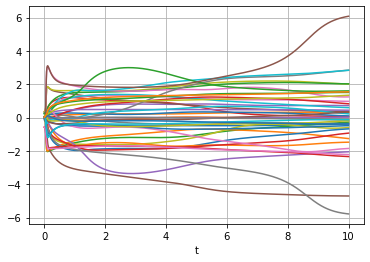

In [28]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.ylim(0,10)
plt.show()

In [29]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(LL+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [30]:
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi

In [31]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [32]:
psi = var_ansatz(start_point,psi_0)

In [33]:
psi_ground = eigenvec[:,0]


In [34]:
expt_value_u = np.zeros(len(time_domain))
energy = np.zeros(len(time_domain))
psi = var_ansatz(start_point,psi_0)
for tt in range(len(time_domain)):
    theta = []
    for i in range(coeff*N):
        theta.append(Y[tt][i])

    psi_var = var_ansatz(theta,psi_0)
    
    for i in range(LL+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

    expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
    energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)


(0.94, 0.98)

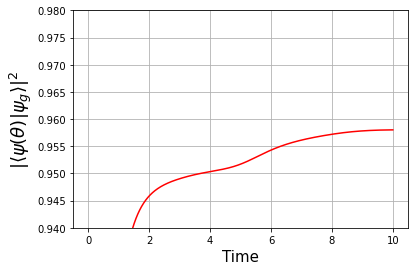

In [35]:
plt.plot(time_domain,expt_value_u, color = "red")
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
#plt.xlim(0,10)
plt.ylim(0.94,0.98)

#plt.savefig("Imaginary_time_evolution_fidelity_2d_1plaquette_M=0.1_N=3.pdf",bbox_inches = "tight")

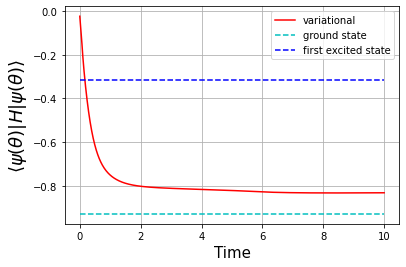

In [36]:
plt.plot(time_domain,energy, color = "red",label = "variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c", label = "ground state")
plt.plot(time_domain,eigenval[1]*np.ones(len(time_domain)), ls = "--", color ="b", label = "first excited state")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
#plt.xlim(0,10)
plt.legend()
#plt.ylim(0.9,0.95)

#plt.savefig("Imaginary_time_evolution_energy_2d_1plaquette_M=0.1_N=3.pdf",bbox_inches = "tight")

In [37]:
print(expt_value_u[-1])

0.9580133635759359


In [ ]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
